# **_<div class="alert alert-success"><font color='darkred'> Tutorials: 02 Machine Learning</font></div>_**

# 1.0 Libraries

To install ```scikit-eo``` you can do it with the following line:

In [ ]:
!pip install scikeo rasterio dbfread

Libraries to be used:

In [ ]:
import rasterio
import numpy as np
from scikeo.mla import MLA
import matplotlib.pyplot as plt
from dbfread import DBF
import matplotlib as mpl
import pandas as pd

## 2.0 Optical image

Landsat-8 OLI (Operational Land Imager) will be used to obtain in order to classify using Random Forest (RF). This image, which is in surface reflectance with bands:
- Blue -> B2
- Green -> B3 
- Red -> B4
- Nir -> B5
- Swir1 -> B6
- Swir2 -> B7

The image and signatures to be used can be downloaded [here](https://drive.google.com/drive/folders/193RhNpACu9THcOZu8OzMh-btnFCOgHrU?usp=sharing):

## 3.0 Supervised Classification using Random Forest

Image and endmembers

In [ ]:
path_raster = r"F:\RepositoriosGitHub\scikit-eo-tutorials\data\02_ml\LC08_232066_20190727_SR.tif"
img = rasterio.open(path_raster)

path_endm = r"F:\RepositoriosGitHub\scikit-eo-tutorials\data\02_ml\endmembers.dbf"
endm = DBF(path_endm)

In [ ]:
# endmembers
df = pd.DataFrame(iter(endm))
df.head()

,class,b1_LC08_23,b2_LC08_23,b3_LC08_23,b4_LC08_23,b5_LC08_23,b6_LC08_23
0,1.0,646,1137,1446,569,53,33
1,1.0,658,1141,1449,585,68,44
2,1.0,663,1149,1455,573,67,43
3,1.0,657,1147,1453,556,48,29
4,1.0,662,1147,1451,557,52,31


Instance of ```mla()```:

In [ ]:
inst = MLA(image = img, endmembers = endm)

Applying Support Vector Machine with 70% of data to train

In [ ]:
import warnings 
warnings.filterwarnings("ignore")

rf_class = inst.SVM(training_split = 0.7)

## 4.0 Results

Dictionary of results

In [ ]:
rf_class.keys()

dict_keys(['Overall_Accuracy', 'Kappa_Index', 'Confusion_Matrix', 'Classification_Map', 'Image'])

Overall accuracy

In [ ]:
rf_class.get('Overall_Accuracy')

0.9166666666666666

Kappa index

In [ ]:
rf_class.get('Kappa_Index')

0.8886149383611313

Confusion matrix or error matrix

In [ ]:
rf_class.get('Confusion_Matrix')

,0,1,2,3,Total,Users_Accuracy,Commission
0,23.000000,0.0,0.0,3.000000,26.0,88.461538,11.538462
1,0.000000,22.0,0.0,1.000000,23.0,95.652174,4.347826
2,1.000000,0.0,26.0,0.000000,27.0,96.296296,3.703704
3,0.000000,3.0,0.0,17.000000,20.0,85.000000,15.000000
Total,24.000000,25.0,26.0,21.000000,NaN,NaN,NaN
Producer_Accuracy,95.833333,88.0,100.0,80.952381,NaN,NaN,NaN
Omission,4.166667,12.0,0.0,19.047619,NaN,NaN,NaN


Preparing the image before plotting

In [ ]:
# convert to array
arr_img = img.read()
# stacking the image
rgb = np.stack([arr_img[4,:,:], arr_img[3,:,:], arr_img[2,:,:]], axis = -1)

# Normalizing bands
def stretch_std(arr, std_val):
    """ Returns the data with a standard deviation contrast applied """
    mean = np.mean(arr)
    std = np.std(arr)*std_val
    min_val = np.max([mean - std, np.min(arr)])
    max_val = np.min([mean + std, np.max(arr)])
    clipped_arr = np.clip(arr, min_val, max_val)
    img = (clipped_arr - min_val)/(max_val - min_val)
    return img

rgb_norm = stretch_std(rgb, 2.5)

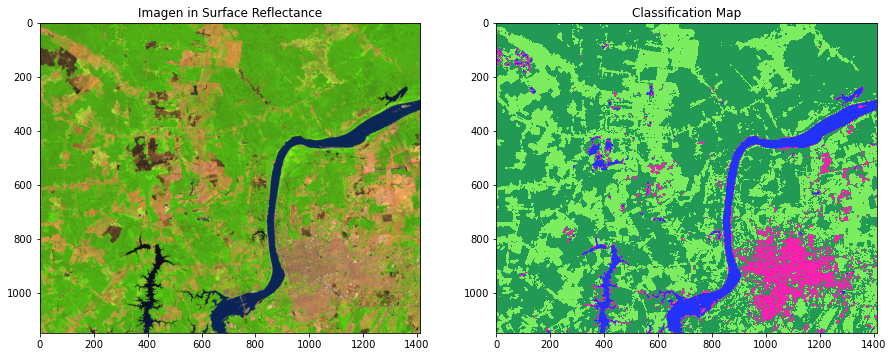

In [ ]:
# Let's define the color palette
palette = mpl.colors.ListedColormap(["#2232F9","#F922AE","#229954","#7CED5E"])

# Let´s plot
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 9))
axes[0].imshow(rgb_norm)
axes[0].set_title("Image in Surface Reflectance")
axes[0].grid(False)

axes[1].imshow(rf_class.get('Classification_Map'), cmap = palette)
axes[1].set_title("Classification Map")
axes[1].grid(False)